TODO - This needs a bunch of rewriting:

- [X] make a class M with num_tetrahedra method
- [x] re-write get_gluing_data
- [ ] find/fix assumptions that every face is glued.
- [ ] hand-craft input data for the two triangulations in the pachner 2-3 move?

# Support and Setup

In [ ]:
#import snappy
#M = snappy.Triangulation('4_1')
#M._two_to_three(0,1)
#num_tet = M.num_tetrahedra()

In [169]:
class FakeTriangulation:
    def __init__(self,num_tet,glued=True):
        self.num_tet = num_tet
        self.glued = glued
        
    def num_tetrahedra(self):
        return self.num_tet
    
    def _get_tetrahedra_gluing_data(self):
        
        if self.glued:
            if self.num_tet == 1:
                fake_gluing_data = [# just one tetrahedra
                    (
                        [0,0,0,0],
                        [[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]]
                    )
                ]
            if self.num_tet == 2:
                fake_gluing_data = [ # two tetrahedra glued along one face.
                    ( # t0
                        [0,0,1,0],
                        [[0,1,2,3],[0,1,2,3],[0,1,3,2],[0,1,2,3]]
                    ),
                    ( # t1
                        [1,1,1,0],
                        [[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,3,2]]
                    )
                ]
            if self.num_tet == 3:
                fake_gluing_data = [ # three tetrahedra glued around a central edge.
                    ( # t0
                        [2,1,0,0],
                        [[1,0,2,3], [3,2,0,1],[0,1,2,3],[0,1,2,3]]
                    ),
                    ( # t1
                        [1,1,0,2],
                        [[0,1,2,3],[0,1,2,3],[2,3,1,0],[2,3,1,0]]
                    ),
                    ( # t2
                        [1,0,2,2],
                        [[3,2,0,1],[1,0,2,3],[0,1,2,3],[0,1,2,3]]
                    )
                ]
        if not self.glued:
            fake_gluing_data = [
                ([t,t,t,t],
                [[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]]
                )
                for t in range(self.num_tet)
            ]
            
        
        return fake_gluing_data
        
    
M = FakeTriangulation(3)
num_tet = M.num_tetrahedra()

## Logging

In [170]:
import logging

# create logger
logger = logging.getLogger(__name__)

# keep from having duplicate messages.
logger.handlers = []
logger.propagate = False

# set log level for all handlers to debug. Options are DEBUG, INFO, WARNING, ERROR, and CRITICAL.
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
# best for development or debugging
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.DEBUG)



# create formatter
formatter = logging.Formatter('%(levelname)s - %(message)s')

# add formatter to ch
consoleHandler.setFormatter(formatter)

# add console hangler to logger
logger.addHandler(consoleHandler)

## Helper methods

In [171]:
# Functions for quantum tori - TODO combine this with the quantum_tori notebook.


def names_to_lattice_coordinate(names,gens_dict):
    """
    Gets the lattice coordinate for a monomial. Assumes the coordinates are
    Weyl normal order, e.g. ['x','y','z'] -> :xyz:
    
    Parameters:
        names (list of strings or dictionary specifying exponents) - generator names
        gens_dict (dict) - maps generator names to lattice coordinates.
    
    Returns:
        vector - the lattice coordinate of the Weyl normal order product of the given generator.
    """
    if isinstance(names,dict): # means powers are specified
        return sum([power*gens_dict[gen] for gen,power in names.items()])
    else: # its a list or set
        return sum([gens_dict[gen] for gen in names])
    
def lattice_coord_to_dict(coord,gens_dict):
    """
    Converts a lattice coordinate to a dictionary with variable names as keys and powers as values.
    Might assume that each generator's coordinate has exactly one non-zero entry.
    
    Parameters:
        coord (list or vector) - the coordinate of an element in the quantum torus
        gens_dict (dict) - the dictionary of generator lattice coordinates.
    
    Returns:
        dict - a dictionary representation of the coordinate.
    """
    dict_form = {}
    for gen_name,gen_coord in gens_dict.items():
        # divide by that entry to deal with qrt2, which is (2,0,...,0)
        # does not handle roots of other generators - they'll be set to zero by int()
        power = int(sum(ii*jj for (ii,jj) in zip(gen_coord,coord))/max(gen_coord))
        if power != 0:
            dict_form[gen_name] = power
    
    return dict_form

def lattice_coord_to_ring_element(coord,the_ring):
    """
    Turns a lattice coordinate into a ring element.
    Assumes that the coordinate and the_ring.gens() use the same order.
    This recreates the functionality of the_ring.monomial, which isn't implemented for all the rings we work with.
    
    Parameters:
    coord (List) - the lattice coordinate of a module element.
    the_ring (fgp_module) - the ambient module
    
    Returns:
    (the_ring.element_class) - the ring element corresponding to the lattice coordinate
    """
    return reduce(the_ring.product, [term[0]**term[1] for term in zip(the_ring.gens(),coord)])

def product_from_lattice_coordinates(*coords, relations=matrix.identity(3), gens_dict={'qrt2':(2,0,0),'A':(0,1,0),'a':(0,0,1)}):
    #TODO - double check that this works like I think it should.
    """
    Gets the lattice coordinate for the product X^coord1 * X^coord2 * ... * X^coordn
    This isn't simple termwise addition because lattice coordinates are in normal order, so we have a factor of q introduced.
    
    If X^coord1 * X^coord2 = q^(2n) X^coord2 * X^coord1, then 
    X^coord1 * X^coord2 = q^(-n) X^(coord1 + coord2)
    
    Parameters:
        coords (vector or list) - an arbitrary number (>=1) of lattice coordinates, in the order they're being multiplied
        relations (matrix) - the relations matrix
        gens_dict (dict) - dictionary with generator names. used to specify q.
    
    Returns:
        vector - the lattice coordinate for the product
    """
    
    get_q_power = lambda c1, c2: -(matrix(c1)*relations*matrix(c2).transpose())[0,0]
    
    return reduce(lambda c1,c2: get_q_power(c1,c2)*vector(gens_dict['qrt2'])/2+vector(c1)+vector(c2),coords)

def product_from_names(*monomials,relations=matrix.identity(3),gens_dict={'qrt2':(2,0,0),'A':(0,1,0),'a':(0,0,1)}):
    """
    Returns the product of the monomials (in normal order) in the form of a dictionary.
    
    Parameters:
        monomials (dict or list of strings) - an arbitrary number (2 or more?) of dictionarys, in the order they're being multiplied.
        relations (matrix) - gives the commutation relations
        gens_dict (dict) - maps variable names to lattice coordinates
    
    Returns:
        dict - the product in normal order.
    """
    
    coords = [names_to_lattice_coordinate(m,gens_dict) for m in monomials]
    
    return product_from_lattice_coordinates(*coords,relations=relations,gens_dict=gens_dict)

def clear_denominator(element):
    """Clears denominator by multiplying through by a monomial."""
    ambient_ring = element.parent()
    
    return ambient_ring.monomial(*[
        -min(powers) for powers in matrix(element.exponents()).transpose().rows()
    ])*element

In [ ]:
product_from_lattice_coordinates(gens_dict['a002'],gens_dict['a001'],gens_dict['a001'],relations=omega_with_q,gens_dict=gens_dict)
product_from_names({'a002':1},{'a001':1},{'a001':-1}, relations=omega_with_q, gens_dict=gens_dict)

In [172]:
def merge_or_add(dict1, dict2):
    """
    A version of dict1 | dict2 which adds the values of repeated keys. Does not overwrite the original dictionaries.
    
    Example:
    merge_or_add({'a':1,'b':-1}, {'b':1,'c':2})
    >> {'a':1, 'b':0, 'c':2}
    
    Parameters:
    dict1 (dict)
    dict2 (dict)
    
    Returns:
    dict
    """
    
    union_keys = set(dict1.keys()) | set(dict2.keys())
    
    return {k : dict1.get(k,0)+dict2.get(k,0) for k in union_keys}


## Lattice Coordinates and Weights.

Also gluing data

In [173]:
# Define q and some of its roots.
q = var('q')
qrt2 = var('qrt2')
qrt4 = var('qrt4')
q = qrt4^4
q = qrt2^2
qrt2 = qrt4^2


# todo - is this coeefs vector still useful?
R.<qrt4> =LaurentPolynomialRing(ZZ)
coeffs = matrix(R,[qrt2^2])


### Weights for Short and Long Edges

In [174]:
# Weights
weights_dict = {}
for t in range(M.num_tetrahedra()):
    weights_dict.update({
        'a{0}01'.format(t) : {'v{0}02'.format(t): 1, 'v{0}03'.format(t): -1},
        'a{0}02'.format(t) : {'v{0}03'.format(t): 1, 'v{0}01'.format(t): -1},
        'a{0}03'.format(t) : {'v{0}01'.format(t): 1, 'v{0}02'.format(t): -1},
        'a{0}10'.format(t) : {'v{0}13'.format(t): 1, 'v{0}12'.format(t): -1},
        'a{0}13'.format(t) : {'v{0}12'.format(t): 1, 'v{0}10'.format(t): -1},
        'a{0}12'.format(t) : {'v{0}10'.format(t): 1, 'v{0}13'.format(t): -1},
        'a{0}20'.format(t) : {'v{0}21'.format(t): 1, 'v{0}23'.format(t): -1},
        'a{0}21'.format(t) : {'v{0}23'.format(t): 1, 'v{0}20'.format(t): -1},
        'a{0}23'.format(t) : {'v{0}20'.format(t): 1, 'v{0}21'.format(t): -1},
        'a{0}30'.format(t) : {'v{0}32'.format(t): 1, 'v{0}31'.format(t): -1},
        'a{0}32'.format(t) : {'v{0}31'.format(t): 1, 'v{0}30'.format(t): -1},
        'a{0}31'.format(t) : {'v{0}30'.format(t): 1, 'v{0}32'.format(t): -1}
    })
    
    weights_dict.update({
        'A{0}01'.format(t) : {'v{0}01'.format(t): 1, 'v{0}10'.format(t): 1},
        'A{0}02'.format(t) : {'v{0}02'.format(t): 1, 'v{0}20'.format(t): 1},
        'A{0}03'.format(t) : {'v{0}03'.format(t): 1, 'v{0}30'.format(t): 1},
        'A{0}12'.format(t) : {'v{0}12'.format(t): 1, 'v{0}21'.format(t): 1},
        'A{0}13'.format(t) : {'v{0}13'.format(t): 1, 'v{0}31'.format(t): 1},
        'A{0}23'.format(t) : {'v{0}23'.format(t): 1, 'v{0}32'.format(t): 1},
    })
    


### Threads and Gluing Data
Including weights for threads

In [175]:
def get_short_edges_in_face(tet,face):
    """
    Returns a list of the short edges contained in a specified face.

    Parameters:
    tet (Integer) - index of the tetrahedron containing the face.
    face (Integer) - index of the face.

    Returns:
    list of str - list of short edges contained in the face.
    """
    edge_indices = [0,1,2,3]
    edge_indices.remove(face)
    return ["a{0}{1}{2}".format(tet,i,face) for i in edge_indices]

def get_long_edges_in_face(tet,face):
    """
    Returns a list of the long edges contained in a specified face.

    Parameters:
    tet (Integer) - index of the tetrahedron containing the face.
    face (Integer) - index of the face.

    Returns:
    list of str - list of long edges contained in the face.
    """
    indices = [0,1,2,3]
    indices.remove(face)
    return ["A{0}{1}{2}".format(tet,indices[i1],indices[i2]) for i1 in range(3) for i2 in range(i1+1,3)]   
        
        
    return ["A{0}{1}{2}".format(tet,i,face) for i in edge_indices]

def get_long_edges_in_tet(tet):
    """
    Returns a list of the long edges contained in a specified face.

    Parameters:
    tet (Integer) - index of the tetrahedron.

    Returns:
    list of str - list of long edges contained in the tet.
    """
    return [name.format(tet) for name in ['A{0}01','A{0}02', 'A{0}03','A{0}12','A{0}13','A{0}23']]
    
    
def get_local_thread_weights(tet,face):
    """
    Finds the weights for the threads that would glue this face to another.

    Parameters:
    tet (Integer) - index of the tetrahedron containing the face
    face (Integer) - index of the face inside the tetrehedron.

    Returns:
    dict {str : Integer} - gives the weights of the threads for each vertex in the face."""
    short_edges = get_short_edges_in_face(tet,face)
    local_thread_weights = {}
    for short_edge in short_edges:
        local_thread_weights.update({
            vertex: -weight for vertex,weight in weights_dict[short_edge].items()
        })

    return local_thread_weights


In [80]:
get_long_edges_in_tet(0)

['A001', 'A002', 'A003', 'A012', 'A013', 'A023']

In [176]:
# turn the gluing data into a dictionary.

def get_gluing_dict(M):
    """
    Reformats the gluing data from a snappy triangulation with n tetrahedra.

    Parameters:
    M (FakeTriangulation)

    Returns
    dict - each item is a permutation:
        'r{i}' specifies which tetrahedrons the faces of the i-th tet ends up in.
        's{i}{j}' specifies the gluing map for the j-th face of the i-th tet.
    """
    gluing_data = M._get_tetrahedra_gluing_data()
    gluing_dict = {}
    for t in range(M.num_tetrahedra()):
        gluing_dict.update({"r{0}".format(t) : gluing_data[t][0] })
        for f in range(4):
            gluing_dict.update({"s{0}{1}".format(t,f) : gluing_data[t][1][f]})
            
    return gluing_dict

In [177]:
# This could be more beautiful.
def get_thread_weights_dict(M):
    """
    Finds the weights_dict for the threads, based on a snappy Triangulation.
    
    Parameters:
    M (snappy.Triangulation)
    
    Returns:
    dict of the form {str: vector} - gives the weights of the T-actions for the threads.
    """
    gluing_dict = get_gluing_dict(M)
    thread_weights_dict = {}
    for t in range(M.num_tetrahedra()):
        for f in range(4):
            face_perm = gluing_dict["s{0}{1}".format(t,f)]
            # ignore unglued faces, which are 
            if gluing_dict["r{0}".format(t)][f] != t or face_perm != [0,1,2,3]:
                local_thread_weights = get_local_thread_weights(t,f)
                # add threads based on where they start. i.e. where they have weight 1.
                starting_here = list(filter(lambda k : local_thread_weights[k] == 1, local_thread_weights.keys()))
                for local_vertex in starting_here:
                    distant_vertex = "v{0}{1}{2}".format(
                        gluing_dict["r{0}".format(t)][f],
                        face_perm[Integer(local_vertex[-2])],
                        face_perm[Integer(local_vertex[-1])]
                    )
                    thread_weights_dict.update({
                        "x{0}_{1}".format(local_vertex[1:], distant_vertex[1:]) : {local_vertex: 1, distant_vertex: -1}   
                    })

    return thread_weights_dict


# Add thread weights to the big weights dictionary.

weights_dict.update(get_thread_weights_dict(M))

In [81]:
weights_dict

{'a001': {'v002': 1, 'v003': -1},
 'a002': {'v003': 1, 'v001': -1},
 'a003': {'v001': 1, 'v002': -1},
 'a010': {'v013': 1, 'v012': -1},
 'a013': {'v012': 1, 'v010': -1},
 'a012': {'v010': 1, 'v013': -1},
 'a020': {'v021': 1, 'v023': -1},
 'a021': {'v023': 1, 'v020': -1},
 'a023': {'v020': 1, 'v021': -1},
 'a030': {'v032': 1, 'v031': -1},
 'a032': {'v031': 1, 'v030': -1},
 'a031': {'v030': 1, 'v032': -1},
 'A001': {'v001': 1, 'v010': 1},
 'A002': {'v002': 1, 'v020': 1},
 'A003': {'v003': 1, 'v030': 1},
 'A012': {'v012': 1, 'v021': 1},
 'A013': {'v013': 1, 'v031': 1},
 'A023': {'v023': 1, 'v032': 1},
 'a101': {'v102': 1, 'v103': -1},
 'a102': {'v103': 1, 'v101': -1},
 'a103': {'v101': 1, 'v102': -1},
 'a110': {'v113': 1, 'v112': -1},
 'a113': {'v112': 1, 'v110': -1},
 'a112': {'v110': 1, 'v113': -1},
 'a120': {'v121': 1, 'v123': -1},
 'a121': {'v123': 1, 'v120': -1},
 'a123': {'v120': 1, 'v121': -1},
 'a130': {'v132': 1, 'v131': -1},
 'a132': {'v131': 1, 'v130': -1},
 'a131': {'v130': 1,

### Lattice Coordinates for Short and Long Edges

In [178]:
num_threads = len(get_thread_weights_dict(M))

# First q. The first lattice is in terms of qrt2 = q^(1/2)
gens_dict = {'qrt2': vector([1] + [0]*(M.num_tetrahedra()*18) + [0]*(num_threads))}

# Generators for the skein algebra of the tetrahedra. Threads (from gluing) come later.
for t in range(M.num_tetrahedra()):
    leading_zeros = 1 + 18*t
    trailing_zeros = 18*(M.num_tetrahedra()-1-t) + num_threads
    # short edges
    gens_dict.update(
        {                        # q + before               short                       long + after + threads
            "a{0}01".format(t) : vector([0]*leading_zeros + [1,0,0,0,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}02".format(t) : vector([0]*leading_zeros + [0,1,0,0,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}03".format(t) : vector([0]*leading_zeros + [0,0,1,0,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}10".format(t) : vector([0]*leading_zeros + [0,0,0,1,0,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}13".format(t) : vector([0]*leading_zeros + [0,0,0,0,1,0,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}12".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,1,0,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}20".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,1,0,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}21".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,1,0,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}23".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,1,0,0,0] + [0]*(6+trailing_zeros)),
            "a{0}30".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,0,1,0,0] + [0]*(6+trailing_zeros)),
            "a{0}32".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,0,0,1,0] + [0]*(6+trailing_zeros)),
            "a{0}31".format(t) : vector([0]*leading_zeros + [0,0,0,0,0,0,0,0,0,0,0,1] + [0]*(6+trailing_zeros))  
        })
    # long edges
    gens_dict.update(
        {
        "A{0}01".format(t) : vector([0]*(leading_zeros+12) + [1,0,0,0,0,0] + [0]*trailing_zeros),
        "A{0}02".format(t) : vector([0]*(leading_zeros+12) + [0,1,0,0,0,0] + [0]*trailing_zeros),
        "A{0}03".format(t) : vector([0]*(leading_zeros+12) + [0,0,1,0,0,0] + [0]*trailing_zeros),
        "A{0}12".format(t) : vector([0]*(leading_zeros+12) + [0,0,0,1,0,0] + [0]*trailing_zeros),
        "A{0}13".format(t) : vector([0]*(leading_zeros+12) + [0,0,0,0,1,0] + [0]*trailing_zeros),
        "A{0}23".format(t) : vector([0]*(leading_zeros+12) + [0,0,0,0,0,1] + [0]*trailing_zeros)
        })
    # I might want to add the swapped indices - right now this would break later code.
    # gens_dict.update(
     #   {
     #       "A{0}10".format(t) : gens_dict["A{0}01".format(t)],
     #       "A{0}20".format(t) : gens_dict["A{0}02".format(t)],
     #       "A{0}30".format(t) : gens_dict["A{0}03".format(t)],
     #       "A{0}21".format(t) : gens_dict["A{0}12".format(t)],
     #       "A{0}31".format(t) : gens_dict["A{0}13".format(t)],
     #       "A{0}32".format(t) : gens_dict["A{0}23".format(t)]
     #   })
    


### Lattice Coordinates for Threads

In [179]:
def add_thread_lattice_coordinates(M,gens_dict):
    """ Adds the threads to the gens_dict.
    Assumes the the thread weights have already been added. Modifies gens_dict.
    
    Parameters:
    M (snappy.Triangulation()) - the triangulated knot complement
    gens_dict (dict {str: vector}) - the lattice coordinates of the generators
    weights_dict (dict {str: vector})- the weights of the generators 
    """
    num_tet = M.num_tetrahedra()
    thread_names = list(get_thread_weights_dict(M).keys())
    for i in range(len(thread_names)):
        gens_dict.update({
            thread_names[i] : vector([0]*(1+18*num_tet+i) + [1] + [0]*(len(thread_names)-i-1))
        })

add_thread_lattice_coordinates(M,gens_dict)

### Vertices

In [180]:
# Vertices

vertices_dict = {}

# make a basis for the vertices. This will be useful for the weights matrix.

for t in range(M.num_tetrahedra()):
    vertices_dict.update(
        {                       
            "v{0}01".format(t) : [0]*(12*t) + [1,0,0,0,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}02".format(t) : [0]*(12*t) + [0,1,0,0,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}03".format(t) : [0]*(12*t) + [0,0,1,0,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}10".format(t) : [0]*(12*t) + [0,0,0,1,0,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}13".format(t) : [0]*(12*t) + [0,0,0,0,1,0,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}12".format(t) : [0]*(12*t) + [0,0,0,0,0,1,0,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}20".format(t) : [0]*(12*t) + [0,0,0,0,0,0,1,0,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}21".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,1,0,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}23".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,1,0,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}30".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,0,1,0,0] + [0]*(12*(num_tet-1-t)),
            "v{0}32".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,0,0,1,0] + [0]*(12*(num_tet-1-t)),
            "v{0}31".format(t) : [0]*(12*t) + [0,0,0,0,0,0,0,0,0,0,0,1] + [0]*(12*(num_tet-1-t))
        })
    

    

In [ ]:
# scratch - visualize the vertices basis 
matrix_plot([list(v) for v in vertices_dict.values()])

## Relations

### Relations for Short and Long Edges.

In [181]:
# first do short edges around a puncture
omega_short_one_puncture = 2*matrix([
    [ 0, 1,-1],
    [-1, 0, 1],
    [ 1,-1, 0]
])
omega_short = matrix.block_diagonal([omega_short_one_puncture]*4)

# columns are At01, At02, At03, At12, At13, At23
omega_short_long = 2*matrix([
    [0,1,1,0,0,0],
    [1,0,1,0,0,0],
    [1,1,0,0,0,0],
    #
    [0,0,0,1,1,0],
    [1,0,0,1,0,0],
    [1,0,0,0,1,0],
    #
    [0,0,0,1,0,1],
    [0,1,0,0,0,1],
    [0,1,0,1,0,0],
    #
    [0,0,0,0,1,1],
    [0,0,1,0,1,0],
    [0,0,1,0,0,1]
])



# columns are short then long
omega_one_tet = block_matrix([
    [omega_short,omega_short_long],
    [-omega_short_long.transpose(),0]
])

In [ ]:
# SCRATCH
omega_one_tet

### Thread Relations

In [182]:
def get_edges_adjacent_to_vertex(vertex,weights_dict):
    """
    Returns a list of generators with non-zero weight at a given vertex.
    
    Parameters:
    vertex (str) - the name of a vertex.
    weights_dict (dict) - the weights dictionary.
    
    Returns:
    list of strings - the names of all edges with non-zero weight at this vertex.
    """
    adjacent_edges = []
    for edge, weights in weights_dict.items():
        if vertex in weights and weights[vertex] != 0:
            adjacent_edges.append(edge)
            
    return adjacent_edges

def get_thread_relations(gens_dict,weights_dict):
    """
    Builds the part of the relations matrix concerning threads.
    """
    thread_names = list(filter(lambda k : k[0] == 'x', gens_dict.keys()))
    thread_relations = []
    
    for thread in thread_names:
        this_threads_relations = []
        for vertex,weight in weights_dict[thread].items():
            tmp_adjacent_edges = get_edges_adjacent_to_vertex(vertex,weights_dict)
            # don't add relations for this thread with itself. 
            tmp_adjacent_edges.remove(thread)
            for edge in tmp_adjacent_edges:
                # commutation relation is the same for all non-thread generators at this vertex.
                if edge[0] == 'x':
                    this_threads_relations.append(weight*gens_dict[edge])
                else:
                    this_threads_relations.append(-weight*gens_dict[edge])
        thread_relations.append(sum(this_threads_relations))
    
    return 2*matrix(thread_relations)




In [52]:
#checks
thread_relations = get_thread_relations(gens_dict,weights_dict)
# split the thread relations into two parts, to help construct the full relations matrix.
omega_thread_non_thread = thread_relations[:,1:18*num_tet+1]
omega_thread_thread = thread_relations[:,18*num_tet+1:]

print(thread_relations[:,18*num_tet+1:].is_skew_symmetric())



True


### Full Relations

In [183]:
# Get the relations matrix, then its kernel

def get_relations_matrix(M,gens_dict,weights_dict,omega_one_tet):
    """Constructs the full relations matrix.
    
    Parameters:
    M (snappy.Triangulation)
    gens_dict (dict)
    weights_dict (dict)
    omega_one_tet (Matrix)
    
    Returns:
    Matrix
    """
    num_tet = M.num_tetrahedra()
    if not M.glued:
        return block_diagonal_matrix(matrix([0]),*[omega_one_tet]*num_tet)
    if num_tet == 1:
        return block_diagonal_matrix(matrix([0]),omega_one_tet)
    
    thread_relations = get_thread_relations(gens_dict,weights_dict)
    
    omega_thread_non_thread = thread_relations[:,1:18*num_tet+1]
    omega_thread_thread = thread_relations[:,18*num_tet+1:]
    
    omega_with_q = block_diagonal_matrix(
        matrix([0]),
        block_matrix([
            [block_diagonal_matrix(*[omega_one_tet]*num_tet),-omega_thread_non_thread.transpose()],
            [omega_thread_non_thread,omega_thread_thread]
        ])
    )
    
    return omega_with_q

omega_with_q = get_relations_matrix(M,gens_dict,weights_dict,omega_one_tet)

center_of_full_lattice = omega_with_q.kernel().basis()

Here are some sanity checks for the relations matrix:

weights_dict and gens_dict have the same order: True
relations matrix is skew symmetric: True
Rank of the center: 9


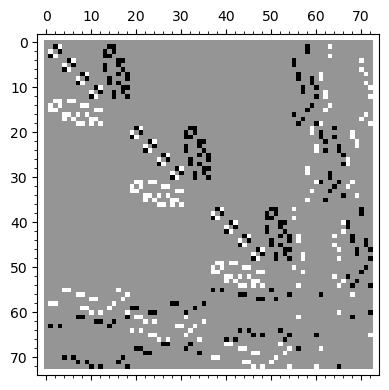

In [53]:
# checking that the keys are in the same order.
print("weights_dict and gens_dict have the same order:", list(weights_dict.keys())==list(gens_dict.keys())[1:])

print("relations matrix is skew symmetric:", omega_with_q.is_skew_symmetric())

print("Rank of the center:",omega_with_q.right_kernel_matrix().rank())

matrix_plot(omega_with_q)
#omega_with_q.rows()

## The Invariant Sublattice
We also make the weight _matrix_ in this section.

In [184]:
def get_weights_matrix(vertices_dict,weights_dict):
    """
    Builds the weights matrix. This is useful for finding invariant sublattices.
    
    Parameters:
    vertices_dict - dictionary {vetrx name: vertex coordinate}
    weights_dict - dictionary {generator name : weight}
    
    Returns
    Matrix - the weights matrix. it's (number generators) x (number vertices)
    """
    # start off with qrt2 - this is weight zero.
    weights_list = [[0]*(len(vertices_dict.keys()))]
    
    for weights in weights_dict.values():
        weights_list.append(sum([
            weight*vector(vertices_dict[vertex]) for vertex,weight in weights.items()
        ]))

    return Matrix(weights_list)

weights_matrix = get_weights_matrix(vertices_dict,weights_dict)
invariant_sublattice = weights_matrix.left_kernel()

T-invariant part is a sublattice of rank 37 Out of 73
Basis for the T-invariant sub-lattice:


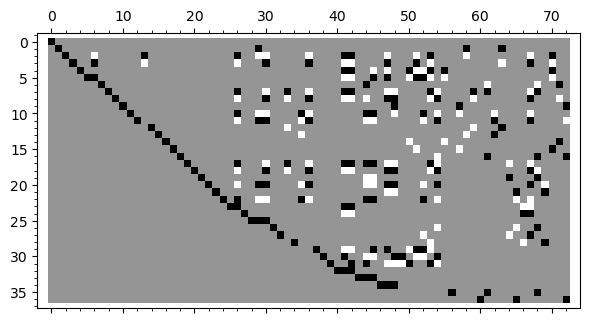

The Weight Matrix:


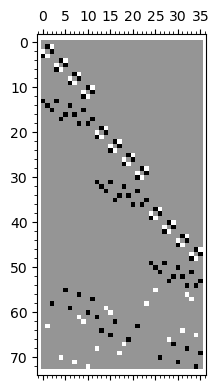

In [83]:
# Some checks.
print("T-invariant part is a sublattice of rank",invariant_sublattice.rank(),"Out of",len(gens_dict))
print("Basis for the T-invariant sub-lattice:")
show(matrix_plot(invariant_sublattice.basis_matrix()))
print("The Weight Matrix:")
show(matrix_plot(weights_matrix))

## Peripheral Curves
This doesn't make sense for us.

In [ ]:
def get_peripheral_curve_dict(M,curve='meridian'):
    """Builds a dictionary from the peripheral curve data.
    
    Parameters:
    M snappy.Triangulation - the triangulation of a knot complement.
    curve string - either 'meridian' or 'longitude'
    
    Returns:
    dict - of the form {'short_edge': weight}. I'm not sure yet what the weights mean.
    """
    all_periph_data = M._get_cusp_indices_and_peripheral_curve_data()[1]
    data_start = {'meridian':0, 'longitude':2}
    
    curve_data = [all_periph_data[i] for i in range(data_start[curve],len(all_periph_data), 4)]

    return {'a{0}{1}{2}'.format(t,v,f):curve_data[t][4*v+f]
            for t in range(M.num_tetrahedra())
            for v in range(4)
            for f in range(4)
            if 0 != curve_data[t][4*v+f]
           }
    

In [ ]:
m_dict_positive = {k:v for k,v in get_peripheral_curve_dict(M).items() if v > 0}
l_dict_positive = {k:v for k,v in get_peripheral_curve_dict(M,curve='longitude').items() if v > 0}

local_weights_dict = {k:v for k,v in weights_dict.items() if k in l_dict_positive.keys()}

print(m_dict_positive)
print(l_dict_positive)

goal_weights = {vertex:-weight for weights in local_weights_dict.values() for vertex,weight in weights.items()}
goal_weights

connector_threads = []
for short_edge in l_dict_positive.keys():
    for vertex,se_weight in weights_dict[short_edge].items():
        tmp_con_th = [ th 
            for th,th_weight in lattice_coord_to_dict(weights_matrix*vector(vertices_dict[vertex]),gens_dict).items()
                      if th[0] == 'x' and th_weight == -se_weight
        ]
        connector_threads += tmp_con_th
        
print(connector_threads)

for th in connector_threads:
    tmp_this_th_overlap = {}
    for se in local_weights_dict.keys():
        tmp_se_th_overlap =  set(weights_dict[se].keys()) & set(weights_dict[th].keys())
        if len(tmp_se_th_overlap) != 0:
            tmp_this_th_overlap.update({se:tmp_se_th_overlap})
    print(th, "overlaps:", tmp_this_th_overlap)
#adjacent_threads = [edge for edge,weights in weights_dict.items() ]

## Constraints Lists

### T-Monodromy Around Punctures

In [185]:
def get_T_monodromy_list(M,gens_dict):
    """
    Constructs the list of T-monodromy expressions. Assumes that gens_dict has the short edges in the right order.
    
    Parameters:
    M (snappy.Triangulation) - the triangulated knot complement
    gens_dict (dict {str:vector}) - the lattice coordinates for the generators of the skein algebra
    
    Returns:
    list of lists of strings - each element is a list of the short edges around a puncture.
    
    """
    num_tet = M.num_tetrahedra()
    # the short edges are listed in gens_dict in the right order.
    short_edge_names = list(filter(lambda name: name[0]=='a', gens_dict.keys()))
    T_monodromy_list = []
    for p in range(num_tet*4):
        T_monodromy_list.append(short_edge_names[3*p:3*p+3])
    
    return T_monodromy_list

T_monodromy_variable_names_list = get_T_monodromy_list(M,gens_dict)
T_monodromy_lattice_coordinate_list = [
    sum([
        gens_dict[name] for name in monodromy
    ]) for monodromy in T_monodromy_variable_names_list
]

for coord in T_monodromy_lattice_coordinate_list:
    if not (matrix(coord)*weights_matrix).is_zero():
        print("Not Invariant:",coord)

### Gluing Relations

In [186]:
def get_long_edge_gluing_relations_list(gens_dict):
    """
    Parameters:
    M (snappy.Triangulation) - the triangulated knot complement.
    gens_dict (dict {str:vector}) - the lattice coordinates for the generators of the skein algebra

    Returns
    list of dicts - gluing relations. keys are generators and values are their powers.
    """
    
    threads_list = list(filter(lambda gen : gen[0] == 'x',gens_dict.keys()))
    
    if len(threads_list) == 0:
        return []
    
    long_edge_gluing_relations_list = []
    th = threads_list[0]
    tmp_gluing_dict = {th:-1}
    
    index_reversal_map = lambda index : index[:-2] + ''.join(reversed(index[-2:]))
    index_sort_map = lambda index : index[:-2] + ''.join(sorted(index[-2:]))
    
    while threads_list:
        other_thread = "x{1}_{0}".format(*[index_reversal_map(index) for index in th[1:].split('_')])
        tmp_gluing_dict[other_thread] = 1
        
        long_edge_pos = "A" + index_sort_map(th[1:].split('_')[0])
        tmp_gluing_dict[long_edge_pos] = 1
        
        long_edge_neg = "A" + index_sort_map(th[1:].split('_')[1])
        tmp_gluing_dict[long_edge_neg] = -1
        
        long_edge_gluing_relations_list.append(tmp_gluing_dict)
        
        # remove these two threads so we don't check them again
        threads_list = list(set(threads_list) - set(tmp_gluing_dict.keys()))
        
        if threads_list == list():
            return long_edge_gluing_relations_list
        else:
            # on to the next one
            th = threads_list[0]
            tmp_gluing_dict = {th:-1}
            

long_edge_gluing_relations_list = get_long_edge_gluing_relations_list(gens_dict)

In [86]:
# Check that all relations are T-invariant, and incidentally that we've listed actual threads.
# It's working well if nothing is printed.

for constraint in long_edge_gluing_relations_list:
    lat_coord = names_to_lattice_coordinate(constraint,gens_dict)
    if not (lat_coord*weights_matrix).is_zero():
        print("Not Invariant!", lat_coord*weights_matrix)
        
#print(long_edge_gluing_relations_list)

In [187]:
def get_short_edge_gluing_relations_list(M,weights_dict):
    """
    Constructs a the list of constraints inclured by gluing together short edges.
    
    Parameters:
    M snappy.Triangulation - the triangulated knot complement.
    weights_dict - the weights of edges. Used to find where edges start/end.
    
    Returns:
    list of lists of strings - elements are lists of generator names. Should be in the right order. 
    """
    gluing_data = get_gluing_dict(M)
    
    short_edge_gluing_relations_list = []
    
    for tet in range(M.num_tetrahedra()):
        for face in range(4):
            new_tet = gluing_data['r{0}'.format(tet)][face]
            if new_tet <= tet: # avoid double-lisitng relations. will still double-list self-foldings.
                gluing_perm = gluing_data['s{0}{1}'.format(tet,face)]
                new_face = gluing_perm[face]
                if new_face != face or new_tet != tet:
                    for short_edge in get_short_edges_in_face(tet,face):
                        distant_short_edge = 'a{0}{1}{2}'.format(new_tet,gluing_perm[Integer(short_edge[-2])],new_face)

                        tmp_local_weights = weights_dict[short_edge]
                        local_starting_vertex = [vertex[1:] for vertex,weight in tmp_local_weights.items() if weight == -1][0]  
                        local_ending_vertex = [vertex[1:] for vertex,weight in tmp_local_weights.items() if weight == 1][0]  

                        tmp_distant_weights = weights_dict[distant_short_edge]
                        distant_starting_vertex = [vertex[1:] for vertex,weight in tmp_distant_weights.items() if weight == -1][0]  
                        distant_ending_vertex = [vertex[1:] for vertex,weight in tmp_distant_weights.items() if weight == 1][0]  

                        short_edge_gluing_relations_list.append([
                            short_edge,'x{0}_{1}'.format(local_starting_vertex,distant_ending_vertex),
                            distant_short_edge,
                            'x{0}_{1}'.format(distant_starting_vertex,local_ending_vertex)
                        ])
    return short_edge_gluing_relations_list

short_edge_gluing_relations_list = get_short_edge_gluing_relations_list(M,weights_dict)

In [87]:
# Check that all relations are T-invariant, and incidentally that we've listed actual threads.
for constraint in short_edge_gluing_relations_list:
    if not (sum([gens_dict[edge] for edge in constraint])*weights_matrix).is_zero():
        print("Not Invariant!", constraint)


### Monodromy Around the Internal Handles
Because we glue close to but not quite up to the long edges, we have some extra handles on the surface that we'd like to do away with.

The idea right now is to work with something like a partial skein-module, which is what we get by restricting to the part of the moduli space where our local systems extend to the interior of these handles.

These relations will depend on the triangulation, but they're always a set of monomials in the threads. If all faces are glued then each thread shows up in exactly one monomial.

In [188]:
def get_internal_edge_monodromy(gens_dict):
    """Constructs expressions for the T-region monodromies around the 'extra handles'
    on the glued surface.
    
    Works based on the thread names. Assumes that the monodromies are each a cycle.
    if they cross themselves or something this probably won't work."""
    
    list_of_monodromies = []
    
    threads_list = [k for k in gens_dict.keys() if k[0] == 'x']
    
    if len(threads_list) == 0: # there are no thread monodromies.
        return list_of_monodromies
    
    th = threads_list[0]
    tmp_monodromy_list = [th]

    while threads_list:
        
        th_end_vertex = th[1:].split('_')[1]
        tmp_next_thread_list = list(filter(lambda thread : thread[1:].split('_')[0] == th_end_vertex,threads_list))
        if len(tmp_next_thread_list) > 0 :
            next_thread = tmp_next_thread_list[0]

            if next_thread in tmp_monodromy_list:
                # we've closed the loop!
                list_of_monodromies.append(tmp_monodromy_list)
                threads_list = list(set(threads_list) - set(tmp_monodromy_list))
                if threads_list == list():
                    return list_of_monodromies
                th = threads_list[0]
                tmp_monodromy_list = [th]
            else:
                tmp_monodromy_list.append(next_thread)
                th = next_thread
        else:
            threads_list = list(set(threads_list) - set(tmp_monodromy_list))
            if threads_list == list():
                return list_of_monodromies
            th = threads_list[0]
            tmp_monodromy_list = [th]
            # this thread doesn't connect to anything.
            
    
internal_edge_monodromy_list = get_internal_edge_monodromy(gens_dict)

In [147]:
# Checks!
print("Constraints should come in pairs of equal length. There should be {0} total if all faces are glued.".format(2*M.num_tetrahedra()))
# 2t because there are 2t pairs of glued faces, t-1 of which don't increase the genus.
# so genus is g = 2t - (t-1) = t+1. We're interested in the T-region torus, so g-1 genus is killed using 2(g-1) = 2t constraints.
for m in internal_edge_monodromy_list:
    print(m)

# Check that all relations are T-invariant
for constraint in internal_edge_monodromy_list:
    if not (sum([gens_dict[edge] for edge in constraint])*weights_matrix).is_zero():
        print("Not Invariant!", constraint)

Constraints should come in pairs of equal length. There should be 6 total if all faces are glued.
['x023_223', 'x223_101', 'x101_023']
['x232_032', 'x032_110', 'x110_232']


## Quotient Lattice


In [189]:
# Take the quotient!
quotient_lattice = invariant_sublattice.quotient(
    [names_to_lattice_coordinate(v,gens_dict) for v in
     internal_edge_monodromy_list
     + short_edge_gluing_relations_list
     + long_edge_gluing_relations_list
     + T_monodromy_variable_names_list
    ]
)

pi = quotient_lattice.coerce_map_from(quotient_lattice.V())

# Looking for a good generator set for the quotient lattice.
# First restrict un-quotiented lattice to just T-region generators.
non_long_edge_generators = list(filter(lambda gen : gen[0] != 'A',gens_dict.keys()))
non_long_edge_lattice = Matrix([gens_dict[gen] for gen in non_long_edge_generators]).row_module().intersection(invariant_sublattice)


#TODO - I just removed the long edge relations. it that the right way to do this?
T_region_quotient_lattice = non_long_edge_lattice.quotient(
    [names_to_lattice_coordinate(v,gens_dict) for v in
     internal_edge_monodromy_list
     + short_edge_gluing_relations_list
     + T_monodromy_variable_names_list
    ]
)

pi_T_region = T_region_quotient_lattice.coerce_map_from(T_region_quotient_lattice.V())

In [190]:
# Lift the generators of the T-region only lattice to the big lattice, then project them into the full quotient lattice.
T_region_basis_in_quotient_lattice = matrix([pi(g.lift()) for g in T_region_quotient_lattice.gens()])

# Include the right kernel of the T_region basis, so we get a full basis for the quotient lattice.
# I got myself confused by the linear algebra, but am pretty sure I want the transpose.
quotient_basis = matrix(T_region_basis_in_quotient_lattice.rows() + T_region_basis_in_quotient_lattice.right_kernel_matrix().rows()).transpose()


# Get the relations matrix for the quotient lattice:
lift_of_quotient_lattice = []
for g in quotient_lattice.gens():
    lift_of_quotient_lattice.append(g.lift())
    
quotient_omega = matrix(lift_of_quotient_lattice)*omega_with_q*matrix(lift_of_quotient_lattice).transpose()

In [149]:
# Checks
print("Invariant sublattice rank:", invariant_sublattice.rank())
print("T-region sublattice of that is rank:", non_long_edge_lattice.intersection(invariant_sublattice).rank())

# Checks -
print("\n"+"Quotient by T-monodromy, short+long edge gluing relations, internal edge monodromy relations. (Skip long edges for T-region lattice.)")
print("If all faces are glued, then including q, we should have {0} generators. ngens:".format(M.num_tetrahedra()+2), quotient_lattice.ngens())
print("The T-region quotient lattice has", T_region_quotient_lattice.ngens(),"generators")

print("\nThe quotient lattice generators:")
# what do these generators look like?
for g in quotient_lattice.gens():
    print(lattice_coord_to_dict(g.lift(),gens_dict))
    
print("\nT-region quotient lattice generators:")
for g in T_region_quotient_lattice.gens():
    print(lattice_coord_to_dict(g.lift(),gens_dict))
    
print("\nQuotient lattice basis matrix should be full rank:")
print("dimension:",quotient_basis.dimensions(),", rank:",quotient_basis.rank())

Invariant sublattice rank: 37
T-region sublattice of that is rank: 24

Quotient by T-monodromy, short+long edge gluing relations, internal edge monodromy relations. (Skip long edges for T-region lattice.)
If all faces are glued, then including q, we should have 5 generators. ngens: 6
The T-region quotient lattice has 1 generators

The quotient lattice generators:
{'qrt2': 1}
{'a002': 1, 'a012': -1, 'A001': 1, 'a121': 1, 'a132': -1, 'a131': -1, 'A123': -1, 'a213': 1, 'a212': 1, 'a232': -1, 'A203': -1, 'A213': 1, 'x003_131': -1, 'x212_120': -1, 'x203_013': 1}
{'a010': 1, 'a213': 1, 'a212': 1, 'a223': -1, 'a232': -1, 'A202': 1, 'A203': -1, 'A212': -1, 'A213': 1, 'x012_202': 1, 'x203_013': 1}
{'a021': 1, 'a121': 1, 'a131': -1, 'A103': 1, 'A123': -1, 'a213': 1, 'a212': 1, 'a232': -1, 'a231': -1, 'A213': 1, 'A223': -1, 'x020_103': 1, 'x101_023': 1, 'x212_120': -1, 'x223_101': 1}
{'a032': 1, 'a121': 1, 'a132': -1, 'a131': -1, 'A113': 1, 'A123': -1, 'a221': 1, 'a223': 1, 'a231': -1, 'A212': 1,

In [152]:
#lifitng the quotient basis:
print("The basis:")
quot_gens = quotient_lattice.gens()
for elem in quotient_basis.columns():
    a_gen = lattice_coord_to_dict(sum([elem[i] * quot_gens[i] for i in range(len(quotient_lattice.gens()))]).lift(),gens_dict)
    print ({k:v for k,v in a_gen.items() if k[0] == 'A'})

The basis:
{}
{'A001': 1, 'A123': -1, 'A203': -1, 'A213': 1}
{'A202': 1, 'A203': -1, 'A212': -1, 'A213': 1}
{'A103': 1, 'A123': -1, 'A213': 1, 'A223': -1}
{'A113': 1, 'A123': -1, 'A212': 1, 'A223': -1}
{'A201': 1, 'A203': -1, 'A212': -1, 'A223': 1}


# Kernel of the Skein Module

In [191]:
def fix_long_edge_indices(dictionary):
    """
    Fixes the indices on the long edge names in a dictionary.
    These sometimes end up being backwards, e.g. A020 instead of A002.
    NOTE: this won't handle the situation where a dictionary has the same edge under two different names.
    
    Parameters:
    dictionary (dict) - the dictionary that needs fixing.
    
    Returns:
    dict - the fixed dictionary.
    
    """
    index_sort_map = lambda index : index[:-2] + ''.join(sorted(index[-2:]))
    
    return {index_sort_map(k) : dictionary[k] for k in dictionary.keys() if k[0] == 'A'} | {k : v for k,v in dictionary.items() if k[0] != 'A'}

## Kernel for one tetrahedron
Here I compare the ideals generated by bird heads and great circles for just one tetrahedron.

In [192]:
quotient_ring = LaurentPolynomialRing(QQ,['qrt2','m','l'] + ['w{0}'.format(i-3) for i in range(3,quotient_lattice.ngens())])
polynomial_ring = PolynomialRing(QQ,['qrt2','l','m'] + ['w{0}'.format(i-3) for i in range(3,quotient_lattice.ngens())])

change_of_basis_matrix = quotient_basis.det()*quotient_basis.inverse()
qrt2 = quotient_ring('qrt2')
qdim2 = -qrt2^2 + -qrt2^-2

In [193]:
generic_crossing_relation = [ # this equals 1 and was found by hand
    {'qrt2':1, 'A{t}13':-1, 'A{t}02':-1, 'A{t}03':1, 'a{t}32':1, 'a{t}01':1, 'A{t}12':1, 'a{t}23':1, 'a{t}10':1},
    {'qrt2':-1, 'A{t}13':-1, 'A{t}02':-1, 'A{t}01':1, 'a{t}03':-1,'a{t}12':-1, 'A{t}23':1, 'a{t}21':-1, 'a{t}30':-1}
]

classical_crossing_relations = []
quantum_crossing_relations = []
for tt in range(M.num_tetrahedra()):
    this_tet_relation = [{k.format(t=tt) : v for k,v in monomial.items()} for monomial in generic_crossing_relation]
    #logger.info(this_tet_relation)
    quotient_tet_relation = [change_of_basis_matrix*vector(pi(names_to_lattice_coordinate(monomial,gens_dict))) for monomial in this_tet_relation]+[quotient_lattice.zero()]
    logger.debug("Tetrahedron {0} crossing relation: {1}".format(tt,quotient_tet_relation))
    specific_crossing_relation = sum([
        lattice_coord_to_ring_element(change_of_basis_matrix*vector(pi(names_to_lattice_coordinate({k.format(t=tt) : v 
            for k,v in monomial.items()},gens_dict))),quotient_ring) 
                for monomial in generic_crossing_relation
    ])
    quantum_crossing_relations.append(specific_crossing_relation)
    classical_crossing_relations.append(polynomial_ring(clear_denominator(specific_crossing_relation.subs({quotient_ring('qrt2'):-1})-1)))
    
logger.info("Classical relations:\n"+str(classical_crossing_relations))
A_poly_candidate = polynomial_ring.ideal(classical_crossing_relations).elimination_ideal([polynomial_ring(str(g)) for g in quotient_ring.gens()[-M.num_tetrahedra()+1:]]).gens()[0]
logger.info("Classical A-polynomial:\n"+str(A_poly_candidate.factor()))

DEBUG - Tetrahedron 0 crossing relation: [(1, 0, 1, -1, 1, 0), (-1, 1, 0, -1, 0, 0), (0, 0, 0, 0, 0, 0)]
DEBUG - Tetrahedron 1 crossing relation: [(1, 0, 0, 1, -1, 0), (-1, 0, 0, 0, -1, 0), (0, 0, 0, 0, 0, 0)]
DEBUG - Tetrahedron 2 crossing relation: [(1, 0, -1, 0, 0, 0), (-1, 0, -1, 0, 0, 1), (0, 0, 0, 0, 0, 0)]
INFO - Classical relations:
[-l*w1 - m - w0, -w0 - w1 - 1, -l - w2 - 1]
INFO - Classical A-polynomial:
l*w0 + l - m - w0
